In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from fem import install

install()

# **Lab 10 - Metodo agli Elementi Finiti (stazionario) - Parte 1**

Il metodo agli elementi finiti (FEM) è una tecnica di risoluzione numerica per equazioni alle derivate parziali, basata sulla discretizzazione di domini spaziali attraverso mesh poligonali (spesso e volentieri triangolari). Nel caso mono-dimensionale, in particolare, ciò si riduce all'introduzione di griglie spaziali.

La peculiarità del FEM è quella di risolvere il problema differenziali in *forma debole*, cioè passando da un'equazione puntuale (definita per ogni $x$ nel dominio), ad una variazionale (definita per ogni funzione test $v$). Per fare ciò, si fa leva su alcuni concetti di Analisi Funzionale, quali: spazi funzionali (Sobolev e Lebesgue), norme integrali, prodotti interni, forme bilineari, funzionali lineari, etc.

## Discretizzazione agli elementi finiti - **Mesh**

L'idea alla base del FEM è quella di discretizzare il dominio spaziale $\Omega$ introducendo una mesh $\mathcal{M}$ partizionata in *elementi*. Scelto un grado polinomiale $r$, quest'ultima viene utilizzata per costruire uno spazio elementi finiti

$$V_{h}\subset L^{2}(\Omega),$$

caratterizzato da tutte quelle funzioni $v_h:\Omega\to\mathbb{R}$ che sono polinomiali a tratti (di grado $r$), cioè, limitatamente ad ogni elemento della mesh, si possono scrivere come polinomi di grado $r$.

Nel caso Lagrangiano, questa costruzione è automaticamente associata, ad una collezione di nodi, $x_{1},\dots,x_{N_h}$, detti *gradi di libertà* (dofs). Questi ultimi, infatti, servono per l'interpolazione locale, che avviene elemento per elemento (similmente alle spline).

In [ ]:
from fem import Line, generate_mesh, FEspace, plot

domain = Line(0, 1)
mesh = generate_mesh(domain, stepsize = 0.25)

V = FEspace(mesh, 1)

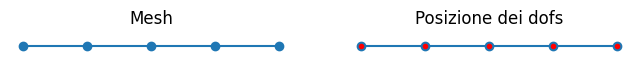

In [ ]:
plt.figure(figsize = (8, 4))
plt.subplot(1, 2, 1)
plot(mesh, title = "Mesh")
plt.subplot(1, 2, 2)
plot(V, title = "Posizione dei dofs")

In [ ]:
from fem import dofs
dofs(V)

array([[1.  ],
       [0.75],
       [0.5 ],
       [0.25],
       [0.  ]])

## Discretizzazione agli elementi finiti - **Funzioni**

Il vantaggio principale è che ogni funzione $f_h\in V_h$ si può rappresentare **univocamente** attraverso il vettore dei suoi valori nodali $\mathbf{f}_h$. Cioè, esiste una corrispondenza 1-a-1

$$V_h\ni f_h\;\;\longleftrightarrow\;\;\mathbf{f}_{h}\in \mathbb{R}^{N_h}$$

dove $\mathbf{f}_{h}=[f_h(x_1),\dots,f_h(x_{N_h})]$ è il vettore di valori nodali.
</br></br>
La corrispondenza è biunivoca perché: data $f_h$, il vettore $\mathbf{f}_h$ si calcola facilmente valutando $f_h$ nei nodi; viceversa, dato il vettore di valori nodali, basta interpolare localmente per ottenere $f_h$.

In [ ]:
from fem import interpolate

f = lambda x: np.sin(2*np.pi*x)*x  # Funzione generica in L2
fh = interpolate(f, V)             # Sua controparte in Vh, ottenuta per interpolazione

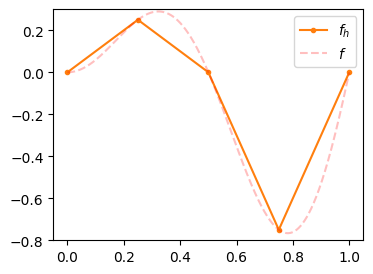

In [ ]:
plt.figure(figsize = (4, 3))
plot(fh, marker = '.', label = '$f_h$')

xplot = np.linspace(0, 1, 1000)
plt.plot(xplot, f(xplot), '--r', label = '$f$', alpha = 0.25)
plt.legend()
plt.show()

In [ ]:
fh(0.25), f(0.25)

(0.25, 0.25)

In [ ]:
fh(0.2), f(0.2)

(0.2, 0.1902113032590307)

In [ ]:
from fem import dof2fun, fun2dof
fh_vect = fun2dof(fh) # Vettore dei valori nodali
fh_vect

array([-2.4492936e-16, -7.5000000e-01,  6.1232340e-17,  2.5000000e-01,
        0.0000000e+00])

In [ ]:
fh_recon = dof2fun(fh_vect, V) # Interpolante ricostruita dai valori nodali (coinciderà con fh!)

<mark>**Esercizio 1**</mark></br>

Le funzioni di base $\varphi_{j}\in V_{h}$ sono quelle funzioni la cui rappresentazione in vettore dof corrisponde ai vettori della base canonica $\mathbf{e}_{j}=[0,0,\dots,1,\dots,0,0]$, dove "l'1" è in posizione $j$.

Si consideri la terza funzione di base, $j=3$, secondo l'ordinamento proposto da FEniCS.

1. Rappresentare graficamente $\varphi_j$,
2. Determinare $x$ tale che $\varphi_{j}(x)=1$.

NB: non fate confusione con l'indicizzazione, ricordate che in Python partiamo a contare da zero!

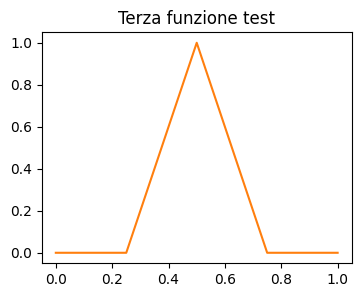

In [ ]:
j = 2
e = np.zeros(V.dim())
e[j] = 1

plt.figure(figsize = (4, 3))
plot(dof2fun(e, V), title = "Terza funzione test")

In [ ]:
dofs(V)[j]

array([0.5])

# Discretizzazione agli elementi finiti - **Funzionali lineari**

Poiché ogni funzione in $V_h$ si rappresenta univocamente con un vettore in $\mathbb{R}^{N_h}$, questo ci permette di rappresentare facilmente anche altri oggetti, tra cui i *funzionali lineari*. Infatti, si dimostra che ad ogni $\ell:V_h\to\mathbb{R}$ lineare corrisponde un $\mathbf{F}\in\mathbb{R}^{N_h}$ tale che</br></br>

$$\ell(v_h)=\mathbf{F}^\top\mathbf{v}_h\quad\quad\forall v_h\in V_h$$

dove $v_h\leftrightarrow\mathbf{v}_h$ come prima.
</br>
</br>
Di seguito un esempio per il funzionale lineare $\ell:\;v_h\mapsto \int x^2 v_h(x)dx$.

In [ ]:
from fem import assemble, dx

f = lambda x: x**2
fh = interpolate(f, V)

def l(v):
  return fh*v*dx

F = assemble(l, V)

In [ ]:
vh = interpolate(lambda x: 1-x, V)
vh = fun2dof(vh) # passaggio a rappresentazione vettoriale

F.T @ vh # Equivalente a calcolare l(vh)!

0.08854166666666667

# Discretizzazione agli elementi finiti - **Forme bilineari**

Analogamente a prima, si dimostra che per ogni forma bilineare $a:V_h\times V_h\to\mathbb{R}$ esiste una matrice $\mathbf{A}\in\mathbb{R}^{N_h\times N_h}$ tale che</br></br>

$$a(u_h,v_h)=\mathbf{u}_h^\top\mathbf{A}\mathbf{v}_h\quad\quad\forall u_h,v_h\in V_h.$$
</br>
</br>
Di seguito un esempio per la forma bilineare $a:\;(u_h,v_h)\mapsto\int u'_h(x)v_h(x)dx$.

In [ ]:
from fem import deriv

def a(u, v):
  return deriv(u)*v*dx

A = assemble(a, V)

In [ ]:
uh = interpolate(lambda x: x**2, V)
vh = interpolate(lambda x: (1-x), V)

uh = fun2dof(uh)
vh = fun2dof(vh)

uh.T @ A @ vh # Equivalente a calcolare a(uh, vh)!

-0.34375

<mark>**Esercizio 2**</mark></br>

Usando lo spazio elementi finiti già costruito, assemblate la forma bilineare

$$m:\;(u,v)\mapsto \int uv dx$$

la cui matrice corrispondente, $\mathbf{M}$,  è detta *matrice di massa*.

Visualizzate la matrice $\mathbf{M}$: è simmetrica? è a dominanza diagonale per righe/colonne? è definita positiva?
</br>
</br>
NB: sfruttate il comando $\texttt{.todense()}$ per passare dal formato sparso a quello "pieno".

In [ ]:
def m(u, v):
  return u*v*dx

M = assemble(m, V)
M.todense()

matrix([[0.08333333, 0.04166667, 0.        , 0.        , 0.        ],
        [0.04166667, 0.16666667, 0.04166667, 0.        , 0.        ],
        [0.        , 0.04166667, 0.16666667, 0.04166667, 0.        ],
        [0.        , 0.        , 0.04166667, 0.16666667, 0.04166667],
        [0.        , 0.        , 0.        , 0.04166667, 0.08333333]])

## Applicazione ai problemi ellittici

Grazie a queste rappresentazioni così efficaci, il FEM ci permette di risolvere equazioni differenziali (lineari) trasformandole in problemi algebrici (sistemi lineari). Vediamolo con un esempio.
</br>
</br>
Sia $\Omega=(a,b)$. Vogliamo risolvere il problema

$$-u'' = f \quad \text{in}\;\Omega,$$

complementato da condizioni di Dirichlet (dbc), $u(a)=\alpha$, $u(b)=\beta$, ai bordi del dominio. Abbiamo

- **Formulazione forte**: trovare $u\in \mathcal{C}^{2}(\Omega)$ soddisfacente le dbc e tale che</br></br>
$$-u''(x)=f(x)\quad\forall x\in\Omega.$$</br>

- **Formulazione debole**: trovare $u\in H^{1}(\Omega)$ soddisfacente le dbc e tale che</br></br>
$$\int_a^bu'v'dx=\int_a^bfvdx\quad\forall v\in H_0^1(\Omega).$$</br>

- **Problema di Galerkin**: trovare $u_h\in V_h$ soddisfacente le dbc e tale che</br></br>
$$\int_a^bu_h'v_h'dx=\int_a^bfv_hdx\quad\forall v_h\in V_h\cap H_0^1(\Omega).$$</br>


- **Formulazione algebrica**: trovare $\mathbf{u}_h\in\mathbb{R}^{N_h}$ soddisfacente le dbc e tale che</br></br>
$$\mathbf{A}\mathbf{u}_h = \mathbf{F}.$$</br>


- **Formulazione algebrica (con dbc)**: trovare $\mathbf{u}_h\in\mathbb{R}^{N_h}$ tale che</br></br>
$$\tilde{\mathbf{A}}\mathbf{u}_h = \tilde{\mathbf{F}}.$$</br>

L'ultimo step si ottiene modificando $\mathbf{A}$ e $\mathbf{F}$ in maniera opportuna, così da includere le condizioni al bordo. Ad es., se $j$ è la componente che fa riferimento al nodo $x_j=a$, si impone $F_j=\alpha$ e si sovrascrive la riga $j$-esima di $\mathbf{A}$ ponendo tutti 0 fuorché in posizione $j$ (dove si mette un 1).
</br>
</br>
Tutto ciò ci permette di trovare $\mathbf{u}_h$, e quindi $u_h$, risolvendo un sistema lineare.


<mark>**Esercizio 3**</mark></br>

Si consideri il seguente problema ellittico,</br></br>

$$\begin{cases}-u'' = e^{2x}\left(3\sin x + 4\cos x\right) & x\in(0,2\pi)\\
\\u(0)=u(2\pi)=0,
\end{cases}$$
</br>
Si risolva numericamente il problema differenziale implementando il metodo agli elementi finiti con $h=0.01$ ed $r=1$.

In [ ]:
# Mesh e spazio elementi finiti
domain = Line(0, 2*np.pi)
mesh = generate_mesh(domain, stepsize = 0.01)
V = FEspace(mesh, 1)

# Assemblaggio del termine noto
f = lambda x: np.exp(2*x)*(3*np.sin(x) + 4*np.cos(x))
fh = interpolate(f, V)
def l(v):
  return fh*v*dx
F = assemble(l, V)

# Assemblaggio della matrice del sistema
def a(u, v):
  return deriv(u)*deriv(v)*dx
A = assemble(a, V)

In [ ]:
# Aggiustamento delle condizioni al bordo
from fem import DirichletBC

def isLeftNode(x):
  return x < 1e-12

def isRightNode(x):
  return x > 2*np.pi - 1e-12

dbc1 = DirichletBC(isLeftNode,  60000.0)
dbc2 = DirichletBC(isRightNode, 0.0)

from fem import applyBCs
A = applyBCs(A, V, dbc1, dbc2)
F = applyBCs(F, V, dbc1, dbc2)

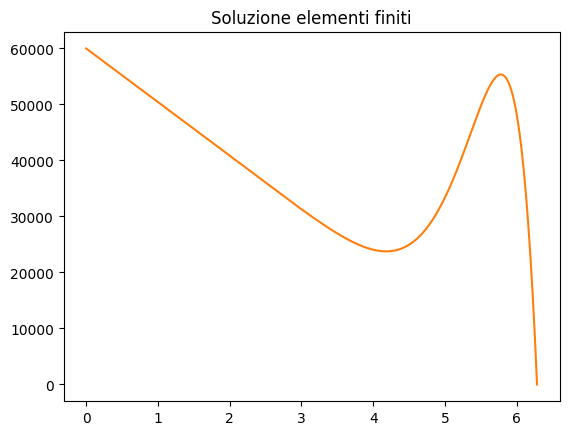

In [ ]:
# Risoluzione del sistema lineare
from scipy.sparse.linalg import spsolve
uh = spsolve(A, F)
uh = dof2fun(uh, V)

plot(uh, title = "Soluzione elementi finiti")

<mark>**Esercizio 4**</mark></br>

Si consideri il problema alle derivate parziali descritto precedentemente. La soluzione esatta di tale problema è

$$u(x)=-e^{2x}\sin(x).$$

Se $u_h$ è la soluzione elementi finiti (come funzione, non come vettore!), il seguente pezzo di codice

    from fem import L2error
    uex = lambda x: -np.exp(2*x)*np.sin(x)
    L2error(uex, uh, domain)

vi permette di calcolare l'errore in norma $L^{2}$, definito dalla formula $\sqrt{\int_a^b|u(x)-u_h(x)|^2dx}$.
</br></br>
Avendo fissato il grado polinomiale della discretizzazione agli elementi finiti, $r=1$, si calcoli l'errore in norma $L^{2}$ tra la soluzione FEM e la soluzione esatta al variare del passo di discretizzazione $h=0.2,0.1,0.05,0.025$. Plottare graficamente l'andamento dell'errore: i risultati sono coerenti con la teoria?

In [ ]:
from fem import L2error

uex = lambda x: -np.exp(2*x)*np.sin(x)
L2error(uex, uh, domain)

86839.0758806248

In [ ]:
r = 1
h = np.array([0.2, 0.1, 0.05, 0.025])
errors = []

for stepsize in h:
  # Generazione della mesh e dello spazio V
  mesh = generate_mesh(domain, stepsize = stepsize)
  V = FEspace(mesh, r)

  # Ri-definizione del termine noto
  fh = interpolate(f, V)
  def l(v):
    return fh*v*dx

  # Assemblaggio e risoluzione del sistema lineare
  A = applyBCs(assemble(a, V), V, dbc1, dbc2)
  F = applyBCs(assemble(l, V), V, dbc1, dbc2)
  uh = spsolve(A, F)
  uh = dof2fun(uh, V)

  # Calcolo dell'errore
  errors.append(L2error(uex, uh, domain))

errors = np.array(errors)

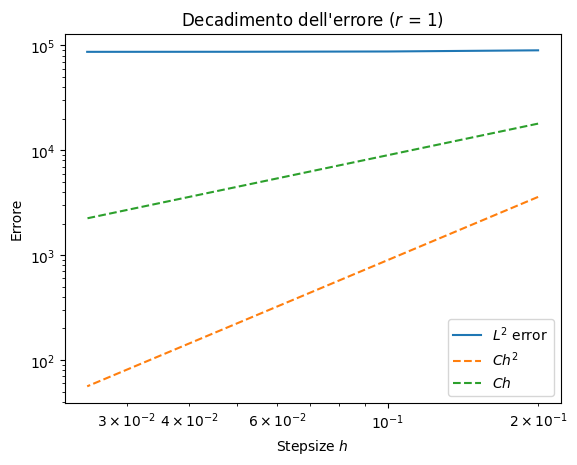

In [ ]:
import matplotlib.pyplot as plt
C = errors.max()
plt.loglog(h, errors , label = '$L^2$ error')
plt.loglog(h, C*h**(r+1), '--', label = '$Ch^%d$' % (r+1))
plt.loglog(h, C*h, '--', label = '$Ch$' )
plt.legend()
plt.title("Decadimento dell'errore ($r$ = %d)" % r)
plt.xlabel("Stepsize $h$")
plt.ylabel("Errore")
plt.show()

# **Extra** - FEM in 2D

In realtà, tutto quello che abbiamo visto si adatta istantaneamente al caso multi-dimensionale! Le grigle diventano mesh, i sotto-intervalli diventano elementi (spesso triangolari), ed i vari operatori differenziali trovano la loro controparte (gradiente, divergenza, rotore... etc.). Di seguito, un esempio di problema ellittico in 2D, per i più curiosi.

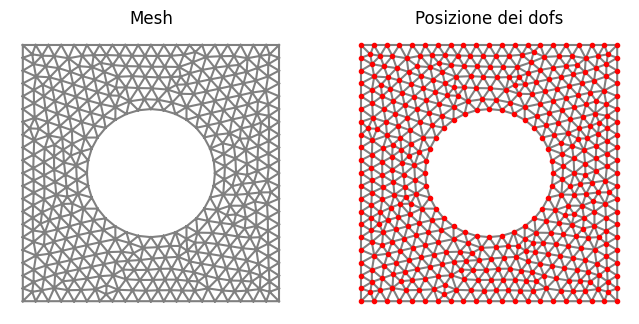

In [ ]:
from fem import Rectangle, Circle
domain = Rectangle((-1, -1), (1, 1)) - Circle((0, 0), 0.5)
mesh = generate_mesh(domain, stepsize = 0.1, structured = True)
V = FEspace(mesh, 1)

plt.figure(figsize = (8, 4))
plt.subplot(1, 2, 1)
plot(mesh, title = "Mesh")
plt.subplot(1, 2, 2)
plot(V, title = "Posizione dei dofs")

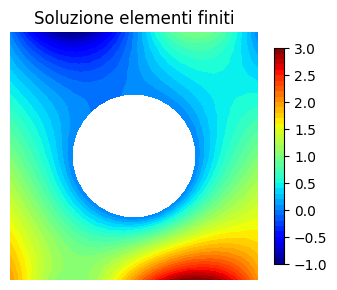

In [ ]:
from fem import inner, grad

f = lambda x, y: 1.0
fh = interpolate(f, V)
l = lambda v: fh*v*dx

isOnCircle = lambda x, y: (x**2 + y**2)**0.5 < 0.5 + 1e-12
isOnSquare = lambda x, y: not isOnCircle(x, y)

dbc1 = DirichletBC(isOnCircle, 0.0)
dbc2 = DirichletBC(isOnSquare, lambda x, y: np.sin(np.pi*x)-y+1)

a = lambda u, v: inner(grad(u), grad(v))*dx

F = applyBCs(assemble(l, V), V, dbc1, dbc2)
A = applyBCs(assemble(a, V), V, dbc1, dbc2)

uh = spsolve(A, F)
uh = dof2fun(uh, V)

plt.figure(figsize = (4, 4))
plot(uh, title = "Soluzione elementi finiti")

## Condizioni di Neumann

Per problemi mono-dimensionali, definiti su un certo intervallo $[a,b]\subset\mathbb{R}$, una condizione al bordo della forma</br></br>
$$u'(b)=\gamma,$$
</br>
o, in alternativa, $u'(a)=\gamma$, è detta condizione di Neumann. Nei metodi agli elementi finiti, questo tipo di condizione viene tipicamente gestita includendo esplicitamente un termine di bordo nella formulazione variazionale. Ad esempio, si consideri il seguente problema con condizioni miste Dirichlet-Neumann,

$$\begin{cases}
-u'' = f & \text{in}\;(a,b)\\\\
u(a)=\alpha,\;\;
u'(b)=\gamma.
\end{cases}$$
</br>
Posto $V_{\text{test}}:=\{v\in H^{1}(a,b)\;|\;v(a)=0\}$, la sua formulazione debole è
</br></br>
$$\int_a^b-u''vdx = \int_a^b fvdx \quad\quad \forall v\in V_{\text{test}}\quad\rightsquigarrow\quad\int_a^bu'v'dx - \left[u'v\right]\Big |^{b}_{a}= \int_a^b fvdx \quad\quad \forall v\in V_{\text{test}}$$
</br>
$$\rightsquigarrow\int_a^bu'v'dx = \int_a^b fvdx + \left[u'v\right]\Big |^{b}_{a}\quad\quad \forall v\in V_{\text{test}}$$
</br>
$$\rightsquigarrow\int_a^bu'v'dx = \int_a^b fvdx + \gamma v(b)\quad\quad \forall v\in V_{\text{test}}.$$

La precedente si può riscrivere con un piccolo trucco di notazione. In generale, data una funzione $g:[a,b]\to\mathbb{R}$, possiamo scrivere
$$\int_{\{a,b\}}gds:=g(a)+g(b),$$
introducendo il cosìdetto *integrale di bordo*, che è definito sull'insieme degli estremi $\{a,b\}$ (integrale 0-dimensionale). Con questo escamotage, la formulazione debole del problema diventa
</br></br>
$$\rightsquigarrow\int_a^bu'v'dx = \int_a^b fvdx + \int_{\{a,b\}}(u'\cdot n) vds\quad\quad \forall v\in V_{\text{test}},$$

dove $n:=\{a,b\}\to\{-1,1\}$ è la *normale esterna*, definita di modo che $n(a)=-1$ ed $n(b)=-1$. In particolare, se definiamo una qualsiasi $\phi:[a,b]\to\mathbb{R}$ tale che

$$\phi(a):=0\quad\text{e}\quad\phi(b):=\gamma,$$

allora, la formulazione debole del problema diventa
</br></br>
$$\rightsquigarrow\int_a^bu'v'dx = \int_a^b fvdx + \int_{\{a,b\}}\phi vds\quad\quad \forall v\in V_{\text{test}},$$

A livello di implementazione, ciò significa, semplicemente, che dobbiamo includere il termine aggiuntivo $\int_{\{a,b\}}\phi vds$ durante l'assemblaggio del termine noto $\mathbf{F}$.
</br>
</br>
</br>
**NOTA BENE**: se le condizioni al bordo vengono invertite, cioè abbiamo Dirichlet a destra, $x=b$, e Neumann a sinistra $x=a$, dovremo definire $\phi$ di modo che $\phi(b)=0$ e $\phi(a)=-\gamma$. **Infatti**, $\phi$ coincide con $u'$ a meno segno, il quale è determinato dalla direzione della normale esterna (vettore **uscente** dall'intervallo).





<mark>**Esercizio 1.1**</mark></br>

Sia $[a,b]\subset\mathbb{R}$ e sia $\gamma\in\mathbb{R}$. Fornire la rappresentazione analitica di due funzioni, $\phi_{\text{left}}$ e $\phi_{\text{right}}$ tali che
</br></br>
$$\phi_{\text{left}}(a)=-\gamma,\quad\phi_{\text{left}}(b)=0,$$
</br>
$$\phi_{\text{right}}(a)=0,\quad\phi_{\text{right}}(b)=\gamma,$$

**Soluzione**. Entrambe le funzioni si possono definire usando delle generiche mappe costanti a tratti. In alternativa, si possono usare anche le seguenti varianti continue:

$$\phi_{\text{left}}(x)=\gamma(x-b)/(b-a),\quad\quad\phi_{\text{right}}(x)=\gamma(x-a)/(b-a)$$

<mark>**Esercizio 1.2**</mark></br>

Si consideri il seguente problema differenziale

$$\begin{cases}
-u''=30x & x\in(0,1)\\
u(0)=0\\u'(1)=3.
\end{cases}$$

Risolvere il problema implementando il metodo agli elementi finiti (grado polinomiale $r=1$, passo della mesh $h=0.1$). Confrontare graficamente la soluzione ottenuta con la soluzione esatta, $u(x)=18x-5x^3.$

In [ ]:
from fem import Line, generate_mesh, FEspace, plot
domain = Line(0, 1)
mesh = generate_mesh(domain, stepsize = 0.1)
V = FEspace(mesh, 1)


from fem import interpolate
f = lambda x: 30*x
fh = interpolate(f, V)

phi = lambda x: 3*x
phih = interpolate(phi, V)


from fem import dx, ds, deriv, assemble
def l(v):
  return fh*v*dx + phih*v*ds

def a(u, v):
  return deriv(u)*deriv(v)*dx

A = assemble(a, V)
F = assemble(l, V)

from fem import DirichletBC, applyBCs
def isLeftNode(x):
  return x < 1e-12

dbc = DirichletBC(isLeftNode, 0.0)
A = applyBCs(A, V, dbc)
F = applyBCs(F, V, dbc)

from scipy.sparse.linalg import spsolve
u = spsolve(A, F)

from fem import dof2fun
u = dof2fun(u, V)

In [ ]:
import matplotlib.pyplot as plt
uex = lambda x: 18*x - 5*(x**3)
xplot = np.linspace(0, 1, 1000)

plt.figure(figsize = (4, 3))
plot(u, label = 'Soluzione FEM', marker = '.')
plt.plot(xplot, uex(xplot), '--', label = 'Soluzione esatta')
plt.legend()
plt.show()

<mark>**Esercizio 1.3**</mark></br>

Ripetere l'Es. 1.2 invertendo le condizioni di Neumann e Dirichlet, cioè risolvendo

$$\begin{cases}
-u''=30x & x\in(0,1)\\
u'(0)=3\\u(1)=0,
\end{cases}$$

la cui soluzione esatta è $u(x)=3x-5x^3+2.$

In [ ]:
domain = Line(0, 1)
mesh = generate_mesh(domain, stepsize = 0.1)
V = FEspace(mesh, 1)

f = lambda x: 30*x
fh = interpolate(f, V)

phi = lambda x: 3*(x-1)
phih = interpolate(phi, V)

def l(v):
  return fh*v*dx + phih*v*ds

def a(u, v):
  return deriv(u)*deriv(v)*dx

A = assemble(a, V)
F = assemble(l, V)

def isRightNode(x):
  return x > 1 - 1e-12

dbc = DirichletBC(isRightNode, 0.0)
A = applyBCs(A, V, dbc)
F = applyBCs(F, V, dbc)

u = spsolve(A, F)
u = dof2fun(u, V)

In [ ]:
import matplotlib.pyplot as plt
uex = lambda x: 3*x - 5*(x**3) + 2
xplot = np.linspace(0, 1, 1000)

plt.figure(figsize = (4, 3))
plot(u, label = 'Soluzione FEM', marker = '.')
plt.plot(xplot, uex(xplot), '--', label = 'Soluzione esatta')
plt.legend()
plt.show()